# FedProx Optimizers


In [1]:
import openfl.native as fx
from openfl.federated import FederatedModel, FederatedDataSet

2023-04-13 18:51:22.112329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 18:51:22.231153: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-13 18:51:22.252903: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-13 18:51:22.652096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Load Dataset and Transfer 
### Define Torch Dataloader

In [2]:
import torch
import torchvision
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Replace here with path of your folder. 
dataset = torchvision.datasets.ImageFolder(root='/home/avinash123/Desktop/Spring 2023/CS6675/FinalProject/archive/gaussian_filtered_images/gaussian_filtered_images', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

### Display data into train and valid sets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

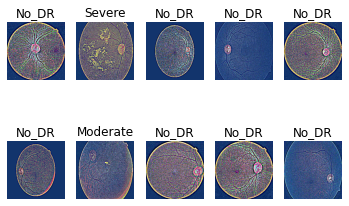

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def index_to_class_name(index, dataset):
    return dataset.classes[index]

len_images = 10
images, labels = next(iter(dataloader))
sample_indices = np.random.choice(len(images), len_images, replace=False)
sample_images = images[sample_indices]
sample_labels = labels[sample_indices]

for i, image in enumerate(sample_images):
    class_name = index_to_class_name(sample_labels[i], dataset)
    plt.subplot(2, 5, i+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(class_name)
    plt.axis('off')

plt.show() 

In [4]:
import matplotlib.pyplot as plt
import numpy as np

### Distribute data into train and valid data sets


In [5]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
data, labels = next(iter(data_loader))
print("The data shape is {}".format(data.shape))

The data shape is torch.Size([3662, 3, 224, 224])


In [6]:
import torch.nn.functional as F
def split_and_return_train_valid(data, labels, split = 0.2):
  test_indices = np.random.rand(data.shape[0]) < split
  train_indices = ~test_indices
  train_data, test_data = data[train_indices], data[test_indices]
  train_labels, test_labels = labels[train_indices], labels[test_indices]
  train_labels, test_labels = F.one_hot(train_labels), F.one_hot(test_labels)
  return train_data, train_labels, test_data, test_labels

train_data, train_labels, test_data, test_labels = split_and_return_train_valid(data, labels) 
print("Train Data Length is {}".format(len(train_data)))
print("Test Data Length is {}".format(len(test_data)))

Train Data Length is 2920
Test Data Length is 742


In [7]:
from openfl.federated import FederatedModel,FederatedDataSet
batch_size = 16
num_classes = 5
fl_data = FederatedDataSet(train_data, train_labels, test_data, test_labels, 
                           batch_size = batch_size , num_classes = num_classes)

###  Define Model - Pretrained Model
We can use a pretrained model like Inception or VGG Net to perform classification. These have already been pretrained on large-scale image data and we need to train only some final linear layers.

In [8]:
from openfl.utilities.optimizers.torch import FedProxOptimizer

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim


class Net(nn.Module):
    def __init__(self, num_classes=5):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.alexnet = models.alexnet(pretrained=True)
        
        for param in self.alexnet.parameters():
            param.requires_grad = False
            
        self.alexnet.classifier[6] = nn.Linear(self.alexnet.classifier[6].in_features, num_classes)

    def forward(self, x):
        x = self.alexnet(x)
        return F.log_softmax(x, dim=1)
    
    def train_epoch(self, batch_generator):
        from openfl.federated.task import PyTorchTaskRunner
        self.optimizer.set_old_weights([p for p in self.parameters()])
        return PyTorchTaskRunner.train_epoch(self, batch_generator)

    
optimizer = lambda x: FedProxOptimizer(x, lr=1e-4, mu=0.8)

def cross_entropy(output, target):
    """Binary cross-entropy metric
    """
    return F.binary_cross_entropy_with_logits(input=output,target=target.float())

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(Net())

## Earlier Parameters: 51386181

/home/avinash123/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avinash123/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


20485

In [11]:
net = Net()
net(data[3:8]).shape

torch.Size([5, 5])

In [10]:
fl_model = FederatedModel(build_model=Net, optimizer=optimizer, loss_fn=cross_entropy, data_loader=fl_data)

tried to remove tensor: __opt_state_needed not present in the tensor dict


### Define OpenFlow Plan

In [11]:
NUM_COLLABORATORS = 5
collaborator_list = [str(i) for i in range(NUM_COLLABORATORS)]
experiment_collaborators = {col_name:col_model for col_name, col_model \
                                 in zip(collaborator_list, fl_model.setup(len(collaborator_list)))}

tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict


In [12]:
fx.init('torch_cnn_mnist', col_names=collaborator_list)

Creating Workspace Directories
Creating Workspace Templates



New workspace directory structure:
workspace
├── save


│   ├── torch_cnn_mnist_last.pbuf
│   ├── torch_cnn_mnist_init.pbuf
│   └── torch_cnn_mnist_best.pbuf
├── src
│   ├── ptmnist_inmemory.py
│   ├── tfmnist_inmemory.py
│   ├── mnist_utils.py
│   ├── __init__.py
│   ├── __pycache__
│   │   ├── __init__.cpython-39.pyc
│   │   └── mnist_utils.cpython-39.pyc
│   ├── pt_cnn.py
│   └── keras_cnn.py
├── agg_to_col_two_signed_cert.zip
├── agg_to_col_one_signed_cert.zip
├── agg_to_col_3_signed_cert.zip
├── agg_to_col_1_signed_cert.zip
├── agg_to_col_4_signed_cert.zip
├── agg_to_col_0_signed_cert.zip
├── data
├── requirements.txt
├── agg_to_col_2_signed_cert.zip
├── plan
│   ├── defaults
│   ├── cols.yaml
│   ├── data.yaml
│   └── plan.yaml
├── logs
│   └── cnn_mnist
│       ├── events.out.tfevents.1681271013.aviLaptop.90469.0
│       ├── events.out.tfevents.1681162787.aviLaptop.21616.0
│       ├── events.out.tfevents.1681422246.aviLaptop.90523.0
│       ├── events.out.tfevents.1681247011.aviLaptop.80923.0
│       ├── events.out.tfevents.168132927

In [13]:
final_fl_model = fx.run_experiment(experiment_collaborators, override_config={"aggregator.settings.rounds_to_train": 20})

[18:09:35] INFO     Updating aggregator.settings.rounds_to_train to 20...                                                                          ]8;id=311648;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/native/native.py\native.py]8;;\:]8;id=656728;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/native/native.py#102\102]8;;\

           INFO     FL-Plan hash is 130b3e0614caa1414f180935e414149febc49b5d6d9ed0eb94f8bddb33780a4523e5deded8710226a18bce74e5d6895d                 ]8;id=212799;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=402575;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py#235\235]8;;\

           INFO     Building 🡆 Object NoCompressionPipeline from openfl.pipelines Module.                                                            ]8;id=306549;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=717044;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py#171\171]8;;\

[18:09:36] INFO     Creating Initial Weights File    🠆 save/torch_cnn_mnist_init.pbuf                                                              ]8;id=883437;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/native/native.py\native.py]8;;\:]8;id=2398;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/native/native.py#277\277]8;;\

           INFO     Starting Experiment...                                                                                                         ]8;id=816765;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/native/native.py\native.py]8;;\:]8;id=791507;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/native/native.py#281\281]8;;\

           INFO     Building 🡆 Object RandomGroupedAssigner from openfl.component Module.                                                            ]8;id=949562;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=159319;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object CutoffTimeBasedStragglerHandling from openfl.component.straggler_handling_functions Module.                    ]8;id=796402;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=797086;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Importing 🡆 Object write_metric from src.mnist_utils Module.                                                                     ]8;id=815673;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=622929;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py#199\199]8;;\

           INFO     Building 🡆 Object Aggregator from openfl.component Module.                                                                       ]8;id=32177;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=628269;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Using custom log metric: <function write_metric at 0x7efc0c087280>                                                          ]8;id=736012;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=168549;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#97\97]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=158729;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=497934;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=464910;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=478783;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=398080;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=410701;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=609866;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=103843;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=322028;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=861448;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=997258;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=573116;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 0                                                                                ]8;id=436144;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=724224;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=509429;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=230169;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[18:09:37] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=241568;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=322428;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:284: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  new_state[k] = pt.from_numpy(tensor_dict.pop(k)).to(device)
/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[18:09:38] METRIC   Round 0, collaborator 0 is sending metric for task aggregated_model_validation: acc     0.136054                         ]8;id=828444;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=557927;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 0                                            ]8;id=376690;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=515125;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validation result acc:      0.136054                                   ]8;id=75371;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=519298;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=18857;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=139056;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 0 round                                                                                                      ]8;id=435494;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=248425;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[18:09:42] METRIC   Round 0, collaborator 0 is sending metric for task train: cross_entropy 0.408645                                         ]8;id=321745;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=608852;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 0                                                                  ]8;id=678348;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=880983;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator metric train result cross_entropy:        0.408645                                                   ]8;id=584269;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=165705;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=346600;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=254219;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[18:09:43] METRIC   Round 0, collaborator 0 is sending metric for task locally_tuned_model_validation: acc  0.632653                         ]8;id=859443;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=219803;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 0                                         ]8;id=7430;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=923640;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validation result acc: 0.632653                                   ]8;id=258209;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=856806;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 0...                                                                                  ]8;id=74086;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=103217;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=493243;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=291488;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 0                                                                                ]8;id=536507;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=296661;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=884200;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=950052;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=403110;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=798259;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[18:09:44] METRIC   Round 0, collaborator 1 is sending metric for task aggregated_model_validation: acc     0.061224                         ]8;id=900888;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=4361;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 0                                            ]8;id=461825;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=712434;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

[18:09:45] METRIC   Round 0, collaborator validate_agg aggregated_model_validation result acc:      0.061224                                   ]8;id=664470;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=207460;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=206018;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=141961;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 0 round                                                                                                      ]8;id=771822;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=243548;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[18:09:49] METRIC   Round 0, collaborator 1 is sending metric for task train: cross_entropy 0.415448                                         ]8;id=513720;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=90593;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 0                                                                  ]8;id=132176;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=282979;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator metric train result cross_entropy:        0.415448                                                   ]8;id=405281;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=759452;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=546604;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=801580;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[18:09:50] METRIC   Round 0, collaborator 1 is sending metric for task locally_tuned_model_validation: acc  0.741497                         ]8;id=762895;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=320088;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 0                                         ]8;id=87130;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=486570;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validation result acc: 0.741497                                   ]8;id=625507;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=724331;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 0...                                                                                  ]8;id=769169;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=509065;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=294963;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=215876;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 0                                                                                ]8;id=803516;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=618852;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=215273;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=512146;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[18:09:51] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=3913;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=932826;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 0, collaborator 2 is sending metric for task aggregated_model_validation: acc     0.142857                         ]8;id=757605;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=461879;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for aggregated_model_validation, round 0                                            ]8;id=795536;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=857294;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validation result acc:      0.142857                                   ]8;id=776064;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=722622;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[18:09:52] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=481265;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=513882;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 0 round                                                                                                      ]8;id=887776;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=396233;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[18:09:56] METRIC   Round 0, collaborator 2 is sending metric for task train: cross_entropy 0.412041                                         ]8;id=296474;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=871034;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for train, round 0                                                                  ]8;id=136912;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=857606;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator metric train result cross_entropy:        0.412041                                                   ]8;id=291685;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=132499;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=764723;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=939929;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[18:09:57] METRIC   Round 0, collaborator 2 is sending metric for task locally_tuned_model_validation: acc  0.585034                         ]8;id=308634;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=38657;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 2 is sending task results for locally_tuned_model_validation, round 0                                         ]8;id=917724;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=421298;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validation result acc: 0.585034                                   ]8;id=819168;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=491379;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 2 for round 0...                                                                                  ]8;id=952601;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=838732;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=585652;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=519727;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 3 for round 0                                                                                ]8;id=695886;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=142877;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=308643;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=376353;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[18:09:58] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=893035;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=13557;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[18:09:59] METRIC   Round 0, collaborator 3 is sending metric for task aggregated_model_validation: acc     0.149660                         ]8;id=733377;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=99526;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for aggregated_model_validation, round 0                                            ]8;id=241188;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=117152;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validation result acc:      0.149660                                   ]8;id=571599;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=575141;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=776102;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=517924;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 0 round                                                                                                      ]8;id=283431;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=908639;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[18:10:03] METRIC   Round 0, collaborator 3 is sending metric for task train: cross_entropy 0.410820                                         ]8;id=859811;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=162480;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for train, round 0                                                                  ]8;id=396651;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=789171;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator metric train result cross_entropy:        0.410820                                                   ]8;id=398184;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=630396;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=708874;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=970442;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[18:10:04] METRIC   Round 0, collaborator 3 is sending metric for task locally_tuned_model_validation: acc  0.585034                         ]8;id=55340;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=151781;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 3 is sending task results for locally_tuned_model_validation, round 0                                         ]8;id=373153;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=79437;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validation result acc: 0.585034                                   ]8;id=860425;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=551117;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 3 for round 0...                                                                                  ]8;id=752977;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=28571;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=639133;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=302665;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 4 for round 0                                                                                ]8;id=704214;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=686522;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=993010;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=63189;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[18:10:05] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=918875;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=563337;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[18:10:06] METRIC   Round 0, collaborator 4 is sending metric for task aggregated_model_validation: acc     0.156463                         ]8;id=539525;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=762971;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for aggregated_model_validation, round 0                                            ]8;id=70201;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=974015;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validation result acc:      0.156463                                   ]8;id=56373;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=194702;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=903504;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=888481;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 0 round                                                                                                      ]8;id=172550;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=484653;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[18:10:10] METRIC   Round 0, collaborator 4 is sending metric for task train: cross_entropy 0.398703                                         ]8;id=328056;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=825265;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 4 is sending task results for train, round 0                                                                  ]8;id=115486;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=108800;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator metric train result cross_entropy:        0.398703                                                   ]8;id=393631;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=913562;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=321569;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=302852;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


KeyboardInterrupt: 

## FedOpt optimizers 
Running the FedOpt Optimizers


In [8]:
from openfl.utilities.optimizers.torch import FedProxOptimizer

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim


class FedOptNet(nn.Module):
    def __init__(self, num_classes=5):
        super(FedOptNet, self).__init__()
        self.num_classes = num_classes
        self.alexnet = models.alexnet(pretrained=True)
        
        for param in self.alexnet.parameters():
            param.requires_grad = False
            
        self.alexnet.classifier[6] = nn.Linear(self.alexnet.classifier[6].in_features, num_classes)

    def forward(self, x):
        x = self.alexnet(x)
        return F.log_softmax(x, dim=1)
    
optimizer = lambda x: optim.Adam(x, lr=1e-4)

def cross_entropy(output, target):
    """Binary cross-entropy metric
    """
    return F.binary_cross_entropy_with_logits(input=output,target=target.float())

In [9]:
from openfl.interface.interactive_api.experiment import TaskInterface, ModelInterface
from openfl.interface.aggregation_functions import AdamAdaptiveAggregation

framework_adapter = 'openfl.plugins.frameworks_adapters.pytorch_adapter.FrameworkAdapterPlugin'

TI = TaskInterface()
MI = ModelInterface(model=FedOptNet(),
                    optimizer=optimizer,
                    framework_plugin=framework_adapter)
...

# Creating aggregation function
agg_fn = AdamAdaptiveAggregation(model_interface=MI,
                                    learning_rate=0.001)

/home/avinash123/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avinash123/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
fl_model = FederatedModel(build_model=FedOptNet, optimizer=optimizer, loss_fn=cross_entropy, data_loader=fl_data)

tried to remove tensor: __opt_state_needed not present in the tensor dict


In [11]:
NUM_COLLABORATORS = 5
collaborator_list = [str(i) for i in range(NUM_COLLABORATORS)]
experiment_collaborators = {col_name:col_model for col_name, col_model \
                                 in zip(collaborator_list, fl_model.setup(len(collaborator_list)))}

tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict


In [12]:
fx.init('torch_cnn_mnist', col_names=collaborator_list)

Creating Workspace Directories
Creating Workspace Templates



New workspace directory structure:
workspace
├── save
│   ├── torch_cnn_mnist_last.pbuf
│   ├── torch_cnn_mnist_init.pbuf
│   └── torch_cnn_mnist_best.pbuf
├── src
│   ├── ptmnist_inmemory.py
│   ├── tfmnist_inmemory.py
│   ├── mnist_utils.py
│   ├── __init__.py
│   ├── __pycache__
│   │   ├── __init__.cpython-39.pyc
│   │   └── mnist_utils.cpython-39.pyc
│   ├── pt_cnn.py
│   └── keras_cnn.py
├── agg_to_col_two_signed_cert.zip
├── agg_to_col_one_signed_cert.zip
├── agg_to_col_3_signed_cert.zip
├── agg_to_col_1_signed_cert.zip
├── agg_to_col_4_signed_cert.zip
├── agg_to_col_0_signed_cert.zip
├── data
├── requirements.txt
├── agg_to_col_2_signed_cert.zip
├── plan
│   ├── defaults
│   ├── cols.yaml
│   ├── data.yaml
│   └── plan.yaml
├── logs
│   └── cnn_mnist
│       ├── events.out.tfevents.1681271013.aviLaptop.90469.0
│       ├── events.out.tfevents.1681423778.aviLaptop.6706.0
│       ├── events.out.tfevents.1681162787.aviLaptop.21616.0
│       ├── events.out.tfevents.1681422246.aviLa

In [ ]:
final_fl_model = fx.run_experiment(experiment_collaborators, override_config={
    "aggregator.settings.rounds_to_train": 20, 
    'tasks.train.aggregation_type': agg_fn})

[18:52:12] INFO     Updating aggregator.settings.rounds_to_train to 20...                                                                          ]8;id=659043;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/native/native.py\native.py]8;;\:]8;id=332881;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/native/native.py#102\102]8;;\

           INFO     Did not find tasks.train.aggregation_type in config. Make sure it should exist. Creating...                                    ]8;id=664943;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/native/native.py\native.py]8;;\:]8;id=852854;file:///home/avinash123/anaconda3/lib/python3.9/site-packages/openfl/native/native.py#105\105]8;;\